# Modular CerberusTS Experimentation

In [1]:
import os
os.chdir("../..")

In [2]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]

In [4]:
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

window_sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)   
}

In [5]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1))

# Prepare the data
preparer.prepare_data()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def ksize(size):
    return max([2, round(size / 9)])

class FormHead(nn.Module):
    def __init__(self, size, feature_len, csize=128, channels=2):
        super(FormHead, self).__init__()
        self.conv = nn.Conv2d(channels, csize, kernel_size=(ksize(size), ksize(feature_len)))
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the output size after convolution and pooling
        conv_output_size = (size - ksize(size) + 1) // 2  # Assuming stride of 1 in conv and 2 in pool
        conv_output_flen = (feature_len - ksize(feature_len) + 1) // 2
        linear_input_size = conv_output_size * conv_output_flen * csize
        # print(linear_input_size)
        self.fc = nn.Linear(linear_input_size, csize)

    def forward(self, x):
        x = F.leaky_relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc(x))
        return x

class Foresight(nn.Module):
    def __init__(self, sizes, feature_indexes, eventualities = 10, csize=128):
        super(Foresight,self).__init__()
        
        call_size = sizes['call']
        res_size = sizes['response']
        call_fl = len(feature_indexes['call'])
        res_fl = len(feature_indexes['response'])
        context_dims = [[sizes[key], len(feature_indexes[key])]  for key in sizes if 'context' in key]

        self.call_head = FormHead(call_size, call_fl, csize)
        self.context_heads = nn.ModuleList([FormHead(icl[0], icl[1], csize) for icl in context_dims])
        self.response_head = FormHead(res_size, res_fl, csize)
        
        self.fc1 = nn.Linear(csize * (2 + len(context_dims)), csize * 16)
        self.fc2 = nn.Linear(csize * 16, csize * 8)
    
        # Parameters for reshaping the output of the linear layer
        self.reshape_channels = csize * 8  # Number of channels after reshaping
        self.reshape_height = res_size
        self.reshape_width = res_fl

        self.expander = nn.Linear(csize * 8 + call_fl, self.reshape_channels * self.reshape_height * self.reshape_width)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(csize * 8, csize * 16, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(csize * 16, eventualities, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               output_padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x_call, x_contexts, x_response, x_lastknown):
        # Produce call, context, and masked response heads
        call_head_out = self.call_head(x_call)
        context_heads_out = [head(x) for head, x in zip(self.context_heads, x_contexts)]
        response_head_out = self.response_head(x_response)
        
        # Use last known value
        last_known = x_lastknown
        
        necks = torch.cat([call_head_out] + context_heads_out + [response_head_out], dim=1)
        necks = F.leaky_relu(self.fc1(necks))
        necks = F.leaky_relu(self.fc2(necks))
        necks = F.leaky_relu(self.expander(torch.cat([necks] + [last_known], dim=1)))
        necks = necks.view(-1, self.reshape_channels, self.reshape_height, self.reshape_width)
        out = self.decoder(necks)
        return out

class EventualityMSELoss(nn.Module):
    def __init__(self):
        super(EventualityMSELoss, self).__init__()

    def forward(self, output, observed):
        """
        output: Tensor of shape [batch_size, 2, timesteps, features]
                - output[:, 0, :, :] is the predicted mean
                - output[:, 1, :, :] is the predicted log variance (for numerical stability)

        observed: Tensor of shape [batch_size, 1, timesteps, features]
        """
        cum_error = 0
        # Separate the mean and variance
        for iev in range(output.shape[1]):
            nll = (observed - output[:,iev,:,:]) ** 2
            cum_error += nll.mean()
        return cum_error
    

In [7]:
foresight = Foresight(sizes,feature_indexes)

In [8]:

num_epochs = 30
prepared_dataloaders = preparer.dataloaders
from accelerate import Accelerator
import torch

# Define a loss function
criterion = EventualityMSELoss()

# Initialize the Accelerator
accelerator = Accelerator()

# Prepare the model and optimizer
optimizer = torch.optim.Adam(foresight.parameters(), lr=0.001)
foresight, optimizer = accelerator.prepare(foresight, optimizer)

# Training Loop
for epoch in range(num_epochs):
    foresight.train()
    running_loss = 0.0

    # Iterator for each prepared DataLoader
    iterators = [iter(dataloader) for dataloader in prepared_dataloaders]

    while True:
        try:
            # Collect batches from each DataLoader
            batches = [next(iterator) for iterator in iterators]
            
            # Prepare data for the model
            calls_batch = next(batch[0] for batch in batches)
            contexts_batch = [batch[1] for batch in batches]
            responses_batch = next(batch[2] for batch in batches)
            last_knowns_batch = next(batch[3] for batch in batches)
            unmasked_batch = next(batch[5] for batch in batches) # Unmasked is stored in the fifth entry

            # Forward and backward passes
            with accelerator.accumulate(foresight):
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = foresight(calls_batch, contexts_batch, responses_batch, last_knowns_batch)
                loss = criterion(outputs, unmasked_batch)

                # Backward pass and optimize
                accelerator.backward(loss)
                optimizer.step()

                running_loss += loss.item()

        except StopIteration:
            # End of epoch
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / sum(len(d) for d in prepared_dataloaders)}")
    

Epoch [1/30], Loss: 5.620341965413342
Epoch [2/30], Loss: 0.015095870240281025
Epoch [3/30], Loss: 0.01426798274119695
Epoch [4/30], Loss: 0.013192287739366293
Epoch [5/30], Loss: 0.012137924780448279
Epoch [6/30], Loss: 0.011252959308524926
Epoch [7/30], Loss: 0.010672295317053795
Epoch [8/30], Loss: 0.010211272649466991
Epoch [9/30], Loss: 0.010218444354832172
Epoch [10/30], Loss: 0.009909312796468535
Epoch [11/30], Loss: 0.009693435666461785
Epoch [12/30], Loss: 0.00959767966841658
Epoch [13/30], Loss: 0.009407583381980658
Epoch [14/30], Loss: 0.009150225023428599
Epoch [15/30], Loss: 0.00888269697315991
Epoch [16/30], Loss: 0.008821737915277482
Epoch [17/30], Loss: 0.008554154910768072
Epoch [18/30], Loss: 0.008518560382847984
Epoch [19/30], Loss: 0.008071120878060658
Epoch [20/30], Loss: 0.007837104713544249
Epoch [21/30], Loss: 0.0077199090210100015
Epoch [22/30], Loss: 0.007514648633077741
Epoch [23/30], Loss: 0.007328562283267577
Epoch [24/30], Loss: 0.007097010885675748
Epoch 

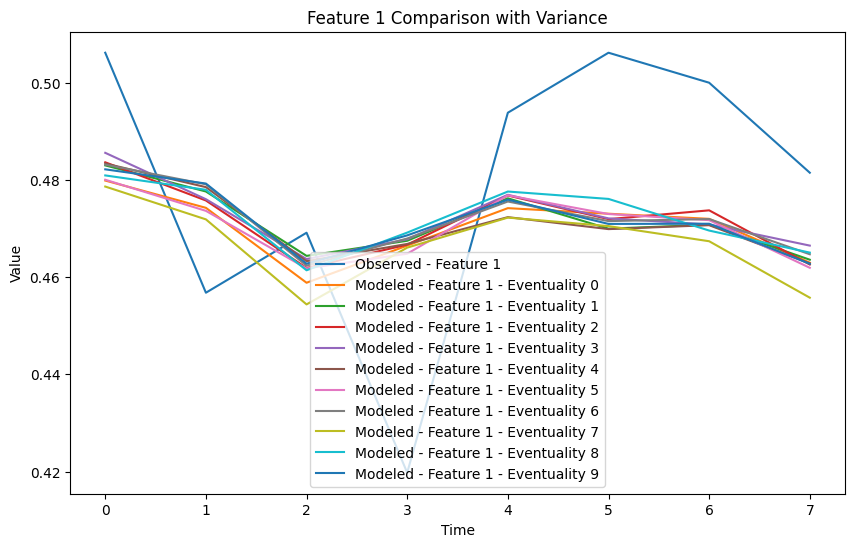

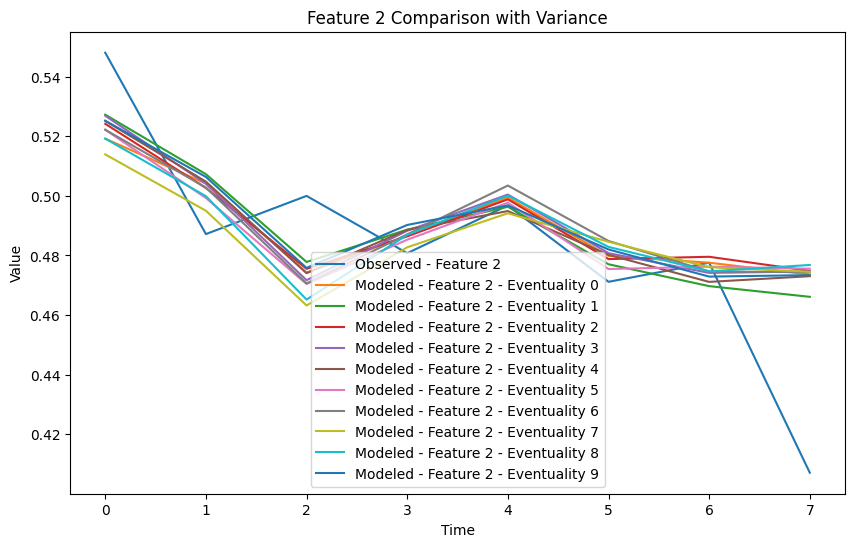

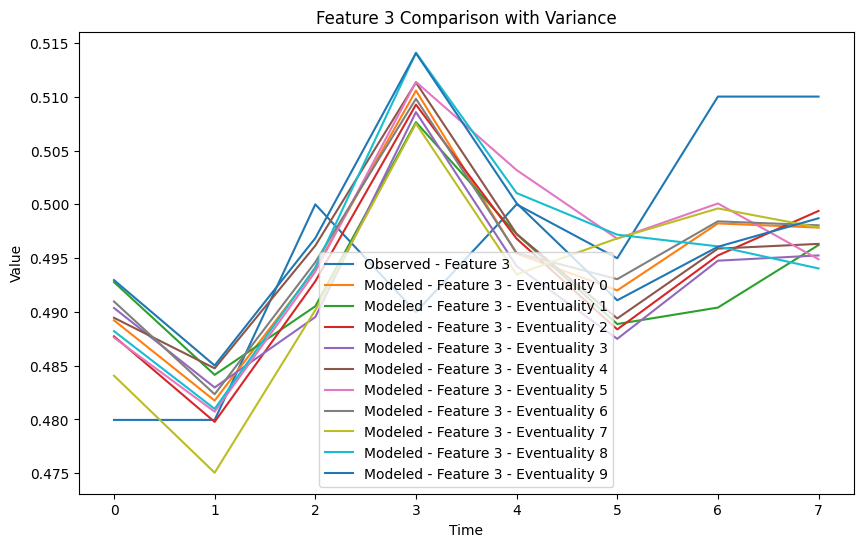

In [10]:
import numpy as np
predictions = outputs
# Example matrices
observed = unmasked_batch[0,:,:].to("cpu").detach()
modeled_mean = predictions[0,0,:,:].to("cpu").detach()

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    
    # Plot observed data
    plt.plot(observed[:, i], label='Observed - Feature {}'.format(i+1))
    
    # Plot modeled data
    for iev in range(predictions.shape[1]):
        modeled_mean = predictions[0,iev,:,:].to("cpu").detach()
        plt.plot(modeled_mean[:, i], label=f'Modeled - Feature {i+1} - Eventuality {iev}')
    
    # Plot settings
    plt.title(f'Feature {i+1} Comparison with Variance')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()